In [1]:
# import skimage
import numpy as np
from skimage import data, io, color, filters, morphology, util
from skimage.io import imsave
# from skimage import exposure, measure, feature, segmentation, restoration
import matplotlib.pyplot as plt
# from skimage.util import img_as_ubyte
import scipy.ndimage as ndi
import pandas as pd
# import seaborn as sns
import os
from PIL import Image

# import torch


# Checking Versions and Conda Env

In [2]:
import matplotlib
print(matplotlib.__version__)
print(matplotlib.__file__)

3.5.1
/ext3/miniconda3/lib/python3.9/site-packages/matplotlib/__init__.py


In [3]:
scripts = os.path.realpath('./')
# scripts = '/scratch/ns4964/lionnet/scripts/'
scripts

'/scratch/ns4964/lionnet/scripts'

In [4]:
os.chdir(scripts)
os.chdir('../inputs/train3D/C1-FB323A_CSC_Rd1_11/')
# bplocal = "D:\\nstitt\\OneDrive\\NYU\\Practicum 2022\\Scripts\\bp_local\\"
# os.chdir(bplocal + "inputs\\train3D\\C1-FB323A_CSC_Rd1_11\\")
os.listdir()

['label.tif', 'image.tif', 'gap.tif']

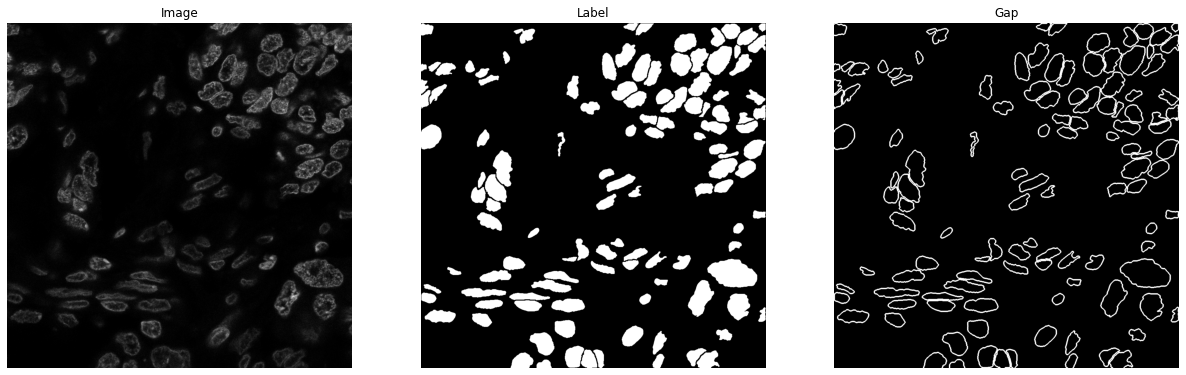

In [5]:
label = Image.open('label.tif')
image= Image.open('image.tif')
gap = Image.open('gap.tif')

plt.figure(figsize=(21,15))

plt.subplot(1,3,1)
plt.title('Image')
plt.axis('off')
plt.imshow(image, cmap = 'gray')

plt.subplot(1,3,2)
plt.title('Label')
plt.axis('off')
plt.imshow(label, cmap = 'gray')

plt.subplot(1,3,3)
plt.title('Gap')
plt.axis('off')
plt.imshow(gap, cmap = 'gray')

(1024, 1024)
(1024, 1024)


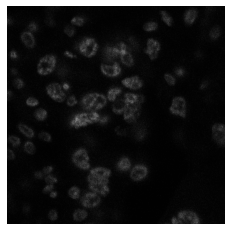

In [6]:
os.chdir(scripts)
os.chdir('../inputs/smFISH/')
# os.chdir(bplocal + "inputs\\smFISH\\")
# os.listdir()
im = 'slide1A_right_BeKi5_HCR_rd2.czi - slide1A_right_BeKi5_HCR_rd2 #01.tif'
test = Image.open(im)
n = np.array(test)

plt.axis('off')
plt.imshow(test, cmap = 'gray')
print(test.size)
print(n.shape)

In [7]:
skimg = io.imread(im, plugin='tifffile')
print(skimg.shape)
print("zslice,channels,height,width")

(23, 5, 1024, 1024)
zslice,channels,height,width


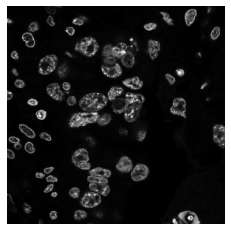

In [8]:
plt.axis('off')
z5ch1 = skimg[5,0]
z5ch2 = skimg[5,1]
plt.imshow(z5ch1,cmap='gray')
# plt.imshow(z5ch2,cmap='gray')


#Full pipeline for splitting pictures

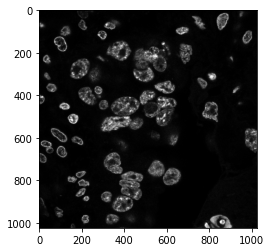

In [9]:
im = 'slide1A_right_BeKi5_HCR_rd2.czi - slide1A_right_BeKi5_HCR_rd2 #01.tif'
skimg = io.imread(im, plugin='tifffile')
z5ch1 = skimg[5,0]
z5ch2 = skimg[5,1]

plt.imshow(z5ch1,cmap='gray')
# plt.imshow(z5ch2,cmap='gray')

(2, 1024, 1024)


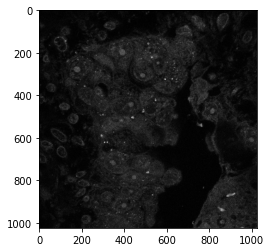

In [10]:
# Create an empty array to add the desired channels into
newtif = np.empty((2,1024,1024))
newtif[0,:,:] = z5ch1
newtif[1,:,:] = z5ch2
print(newtif.shape)
plt.imshow(newtif[1,:,:],cmap='gray')
# imsave('test.tif', newtif)

# Setting up, testing for batch

## Organizing only the images into a dataframe

In [ ]:
# Pulling only image files
imgfiles=[]
basepath = os.path.realpath('./')
for fname in os.listdir(basepath):
    path = os.path.join(basepath, fname)
    if os.path.isdir(path):
        # skip directories
        continue
    imgfiles.append(path)
imgfiles

In [38]:
# Make imagedf dataframe,
imgdf = pd.DataFrame({'fullpath':imgfiles})
# imgdf.assign(full_path = lambda dataframe: dataframe['OrigName'].map(lambda OrigName: os.path.realpath(OrigName) ))
imgdf = imgdf.assign(imgname = lambda dataframe: dataframe['fullpath'].map(lambda fullpath:(fullpath.split(' - ')[1]).split('.')[0]))
imgdf.head()

,fullpath,imgname
0,/scratch/ns4964/lionnet/inputs/smFISH/slide1A_...,slide1A_right_BeKi5_HCR_rd2 #05
1,/scratch/ns4964/lionnet/inputs/smFISH/slide1A_...,slide1A_right_BeKi5_HCR_rd2 #09
2,/scratch/ns4964/lionnet/inputs/smFISH/slide1A_...,slide1A_right_BeKi5_HCR_rd2 #11
3,/scratch/ns4964/lionnet/inputs/smFISH/slide1A_...,slide1A_right_BeKi5_HCR_rd2 #07
4,/scratch/ns4964/lionnet/inputs/smFISH/slide1A_...,slide1A_right_BeKi5_HCR_rd2 #03


### String Split Testing

In [29]:
# Breaking down the string splits
## Pull an image
a = imgdf.fullpath[1]
# Split on the dash
b = a.split(' - ')[1]
c = b.split('.')[0]
c

z = ((imgdf.full_path[1]).split(' - ')[1]).split('.')[0]
z

'slide1A_right_BeKi5_HCR_rd2 #09'

##Make a Function for generating tifs

In [ ]:
# make a function from the tif creation pipeline
def TwoChannelSingleZ(image, zstack, channel1, channel2):
    im = image
    skimg = io.imread(im, plugin='tifffile')
    newtif = np.empty((2,1024,1024))
    newtif[0,:,:] = skimg[zstack,channel1]
    newtif[1,:,:] = skimg[zstack,channel2]
    return newtif

### Function Testing

In [ ]:
# a = imgdf.fullpath[1]
# b = TwoChannelSingleZ(a,5,0,1)
# print(b.shape)
# plt.imshow(b[1,:,:],cmap='gray')
# testnumber = 1
# savename = './singleztifs/test_zstack'+str(testnumber)+'.tif'
# savename
# imsave(savename, b)

# Running it

In [67]:
# Define vars
channel1 = 0 #dapi/nuclear
channel2 = 1 #some FISH stain
zstack = 5 #randomly chosen, seems to be in focus

for i in imgdf.index:
    name = imgdf.iloc[i]['imgname']
    path = imgdf.iloc[i]['fullpath']
    singletif = TwoChannelSingleZ(path, zstack, channel1, channel2)
    savename = './singleztifs/'+str(name)+'_zstack_'+str(zstack)+'.tif'
    imsave(savename, singletif)

/state/partition1/job-15932921/ipykernel_479781/2216372051.py:11: UserWarning: ./singleztifs/slide1A_right_BeKi5_HCR_rd2 #17_zstack_5.tif is a low contrast image
  imsave(savename, singletif)


# Experimenting

## Trying to make a gif from the TIFs

In [ ]:
import glob
from PIL import Image

# filepaths
os.chdir(scripts)
os.chdir('../inputs/smFISH/')
fp_in = "slide1A_*.tif"
fp_out = "test.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=300, loop=0)